# Train from specified config files

In [6]:
# See available GPU RAM 
# !nvidia-smi # can also be run from linux shell while GPU is training
# !nvidia-smi dmon # this will stream memory utilisation
# !watch -n0.1 nvidia-smi # better way to see GPU utilisation
# !htop # cpu threads and if they're all working
# !pip3 install --no-cache-dir -I tensorflow==2.2 # use if no gpu is attached so code will run 
# !sudo kill -9 PID # clear GPU memory where 9 is PID number

In [1]:
# This cell has the latest set up for AI Platform

from __future__ import print_function
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
import os
import glob
import cv2
from io import BytesIO
from PIL import Image
from numpy import expand_dims
import tensorflow.keras
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import *
import warnings
import logging
from IPython.display import clear_output
from collections import Counter
import pickle
import json
import sys
sys.path.insert(1, '/home/jupyter/DeepFake-2019-20/augmentations')
sys.path.insert(1, '/home/jupyter/DeepFake-2019-20/hyperparameters')
sys.path.insert(1, '/home/jupyter/DeepFake-2019-20/visualisations')
import VisualisationTools as plotting
import hyper_utils as hp

warnings.filterwarnings("ignore")
logger = logging.getLogger()
logger.setLevel(100)
plot_losses = plotting.PlotLearning()
os.chdir('/home/jupyter/DeepFake-2019-20')

# # Augmentation libraries
# import face_recognition
# import cutout_augmentation as ca

print("Tensorflow version:", tf.__version__)

Tensorflow version: 2.2.0-dlenv


In [2]:
# Specify config file
config_number=2026
config_file='config{}'.format(config_number)

params = {'architecture': 'mobilenet',
 'epochs': 25,
 'batch_size': 32,
 'learning_rate_type': 'constant',
 'learning_rate': 0.00002,
 'patience': 6,
 'weight_initialisation': 'imagenet',
 'optimiser': 'adam',
 'momentum': 0.1,
 'nesterov': True,
 'label_smoothing': 0.01,
 'dropout': 0.5,
 'target_size': 224,
 'class_weights': True,
 'warmup_epochs': 3}

params

{'architecture': 'mobilenet',
 'epochs': 25,
 'batch_size': 32,
 'learning_rate_type': 'constant',
 'learning_rate': 2e-05,
 'patience': 6,
 'weight_initialisation': 'imagenet',
 'optimiser': 'adam',
 'momentum': 0.1,
 'nesterov': True,
 'label_smoothing': 0.01,
 'dropout': 0.5,
 'target_size': 224,
 'class_weights': True,
 'warmup_epochs': 3}

## Build model

In [3]:
def build_model(dropout, lr_rate, architecture, frozen_base=True):
    '''Builds a specified network with the selected dropout after the last dense layer.

    Architectures that can be selected are:
    vgg, xception, resnet50, mobilenet, efficientnet, densenet
    
    Optimiser is Adam, with a provided learning rate (lr_rate) and fixed
    decay 1e-6, loss is traditionally categorical_crossentropy.'''

    from tensorflow.keras.preprocessing import image
    from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

    if architecture=='xception':
        from tensorflow.keras.applications.xception import Xception
        conv_base = Xception(weights='imagenet', include_top=False,
                        input_shape=(224,224,3))

    elif architecture=='vgg':
        from tensorflow.keras.applications.vgg16 import VGG16
        conv_base = VGG16(weights='imagenet', include_top=False,
                        input_shape=(224,224,3))
      
    elif architecture=='resnet50':
        from tensorflow.keras.applications.resnet50 import ResNet50
        conv_base = ResNet50(weights='imagenet', include_top=False,
                        input_shape=(224,224,3))
      
    elif architecture=='mobilenet':
        from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
        conv_base = MobileNetV2(weights='imagenet', include_top=False,
                        input_shape=(224,224,3))

    elif architecture== 'efficientnet':
        # EfficientNetB7 has the highest top-1 accuracy on imagenet
        # among EfficientNextB{0:7}
        !pip install git+https://github.com/qubvel/efficientnet
        from efficientnet.tfkeras import EfficientNetB0
        conv_base = EfficientNetB0(weights='noisy-student', include_top=False,
                        input_shape=(224,224,3))
        
    elif architecture== 'densenet':
        from tensorflow.keras.applications.densenet import DenseNet201
        conv_base = DenseNet201(weights='imagenet', include_top=False,
                        input_shape=(224,224,3))

    elif architecture not in ['vgg', 'xception', 'resnet50',
                              'mobilenet', 'efficientnet', 'densenet']:
        return "An unknown network is specified"
    

    outputconv_base = conv_base.output
    t_flat = Flatten()(outputconv_base)
    t_dense1 = Dense(1024, activation='relu')(t_flat)
    t_dense2 = Dense(256, activation='relu')(t_dense1)
    t_dense3 = Dense(128, activation='relu')(t_dense2)
    t_do = Dropout(dropout)(t_dense3)
    predictions = Dense(2, activation= 'softmax')(t_do)

    model = Model(inputs=conv_base.input, outputs=predictions, name = 'model')
    
    if frozen_base:
        conv_base.trainable = False # freeze the convolutional base
        
    else: 
        conv_base.trainable = True


    if params['optimiser']=='adam':
        opt = tf.keras.optimizers.Adam(learning_rate=lr_rate)
#         opt = tf.keras.optimizers.Adam(learning_rate= lr_rate, decay=1e-6)
    
    elif params['optimiser']=='sgd':
        tf.keras.optimizers.SGD(learning_rate=lr_rate, momentum=params['momentum'], nesterov=params['nesterov'])

    model.compile(loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=params['label_smoothing']),
                  optimizer=opt,
                  metrics=['accuracy'])
    return model

## Augment data

In [4]:
def augment_data(directory, batch):
    '''Prepares train-time augmentation using given training and validations data)
    
    Returns train_data, val_data'''

    datagen_train = ImageDataGenerator(
            featurewise_center=False,  # set input mean to 0 over the dataset
            samplewise_center=True,  # set each sample mean to 0
            featurewise_std_normalization=False,  # divide inputs by std of the dataset
            samplewise_std_normalization=True,  # divide each input by its std
            zca_whitening=False,  # apply ZCA whitening
            zca_epsilon=1e-06,  # epsilon for ZCA whitening
            rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
            # randomly shift images horizontally (fraction of total width)
#             width_shift_range=0.1,
            # randomly shift images vertically (fraction of total height)
#             height_shift_range=0.1,
            shear_range=0.,  # set range for random shear
            zoom_range=0.,  # set range for random zoom
            channel_shift_range=0.,  # set range for random channel shifts
            # set mode for filling points outside the input boundaries
            fill_mode='nearest',
            cval=0.,  # value used for fill_mode = "constant"
            brightness_range=[0.6, 1.4],
            horizontal_flip=True,  # randomly flip images
            vertical_flip=False,  # randomly flip images
            # set rescaling factor (applied before any other transformation)
            rescale=None,
            # set function that will be applied on each input
            preprocessing_function=None,
            # image data format, either "channels_first" or "channels_last"
            data_format=None,
            # fraction of images reserved for validation (strictly between 0 and 1)
            )
    
    datagen_test = ImageDataGenerator(samplewise_center=True, samplewise_std_normalization=True)

    # Classes give the folders storing the two different categories
    train_data = datagen_train.flow_from_directory('../all_faces_disk/home/jupyter/augmented_all_faces/GridMask-Alt/forensics_split/train',
                                             target_size=(params['target_size'], params['target_size']), batch_size = batch)
    
    val_data = datagen_test.flow_from_directory(directory + '/validation',
                                             target_size=(params['target_size'], params['target_size']), batch_size = batch)
    
    return train_data, val_data

## Auxiliary train time functions

In [5]:
def calculate_class_weights(train_data):
    '''Calculates class weights that weight the data based on the imbalance.
    Allows for better analysis in the case of imbalanced data - has no effect
    if data is balanced since the weights are then equal for each class.
    Use the generator obtained from the flow_from_directory method to obtain
    the class_weights.
    
    Input:
    train_data: the generator obtained during augmentation
    
    Returns a dictionary with class weights, required format for training'''
    
    # Calculate class weights which are required to fully balance the classes
    # Compares frequencies of appearence for each distinct label
    
    # The line of code below can be used on a generator to find the index labels
    print('Ensure class weights function corresponds to these class indices:',
          train_data.class_indices)
    
    counter = Counter(train_data.classes)                          
    max_val = float(max(counter.values()))       
    class_weights = {class_id : max_val/num_images for class_id, num_images in counter.items()}                     

    return class_weights

def load_model_weights(model, architecture):
    '''An alternative to training if there are already some generated weights
    
    Takes a built model (and its architecture type) and loads the weights
    with the highest validation accuracy.
    
    If there are no saved weights, a message is printed.'''

    path_to_weights = "../all_faces_bucket/trained_models/weights/{}".format(config_file)
    # get all the weights file names in a list
    if os.path.exists(path_to_weights):
        all_weights = sorted(os.listdir(path_to_weights + '/'))
    # If there is at least one file
        if len(all_weights) >= 1:
            # Use weights from highest val acc
            model.load_weights(path_to_weights + '/' + 'highest_val_acc.hdf5')
            
        else: # otherwise warn that no weights were loaded
            print("There are no weights stored. Training model from scratch:")   
    
    else: # otherwise warn that no weights were loaded
        print("There are no weights stored. Training model from scratch:")   
        
def save_model_from_best_weights(dropout, lr_rate, architecture, frozen_base):
    '''Takes the weights with the highest val accuracy and saves the corresponding model.'''
    model = build_model(dropout, lr_rate, architecture, frozen_base)
    load_model_weights(model, architecture)
    model.save('../all_faces_bucket/trained_models/saved_models/{}.h5'.format(config_file))    

## Training functions

In [6]:
def train_model(model, train_data, val_data, epochs, class_weights, architecture, lr_rate):
    '''Trains a provided model.
    Takes 6 arguments:
    
    1. model: a built model with an architecture specified in the build function
    2. train_data: augmented data obtained from the augment_data function
    3. val_data: validation data obtained from the augment_data function
    4. epochs -- number of epochs
    5. class weights -- a dictionary with weights (equal for balanced data so
    no negative impact)
    6. architecture: can choose vgg, xception, resnet50, mobilenet or efficientnet
    7. lr_rate: initial learning rate
    '''
    
    # Make a trained_models folder if it doesn't exist
    if not os.path.exists('../all_faces_bucket/trained_models'):
        os.makedirs('../all_faces_bucket/trained_models')
    
    # Make a weights folder if it doesn't exist
    if not os.path.exists('../all_faces_bucket/trained_models/weights'):
        os.makedirs('../all_faces_bucket/trained_models/weights')
        
    # Make a weights folder for the architecture if it doesn't exist
    if not os.path.exists('../all_faces_bucket/trained_models/weights/{}'.format(config_file)):
        os.makedirs('../all_faces_bucket/trained_models/weights/{}'.format(config_file))

    # Below saves on file - the weights with the highest validation accuracy
    filepath="../all_faces_bucket/trained_models/weights/{}/highest_val_acc.hdf5".format(config_file)
    checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', 
                                verbose=1, save_best_only=True, mode='max')
    
    # Make a folder to store training accuracies if it doesn't exist
    if not os.path.exists('../all_faces_bucket/trained_models/training_accuracies'):
        os.makedirs('../all_faces_bucket/trained_models/training_accuracies')
    
    # Callback to save training accuracies after each epoch
    csv_logger = CSVLogger('../all_faces_bucket/trained_models/training_accuracies/{}.csv'.format(config_file),
                           separator=',', append=True)
    
    # Stop after 3 epochs if val_accuracy doesn't improve
    es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=params['patience'])
                          
    # Load previous weights from training if there are any
    load_model_weights(model, architecture)
    
    if params['learning_rate_type']=='cosine_decay':
        # Set learning rate config 
        sample_count = train_data.n # number of training samples
        epochs = epochs # total epochs - affects total steps (and hence speed of decay)
        warmup_epoch = params['warmup_epochs'] # number of warmup epochs
        batch_size = train_data.batch_size
        learning_rate_base = lr_rate
        total_steps = int(epochs * sample_count / batch_size)

        warmup_steps = int(warmup_epoch * sample_count / batch_size)

        warm_up_lr = hp.WarmUpCosineDecayScheduler(learning_rate_base=learning_rate_base,
                                            total_steps=total_steps,
                                            warmup_learning_rate=0.0,
                                            warmup_steps=warmup_steps,
                                            hold_base_rate_steps=2,
                                            verbose=0)

        cb = [plot_losses, checkpoint, csv_logger, es, warm_up_lr]
        
    elif params['learning_rate_type']=='constant':
        cb = [plot_losses, checkpoint, csv_logger, es]
        
    elif params['learning_rate_type']=='increasing':
        pass

    history = model.fit(train_data, epochs=epochs,
              steps_per_epoch = train_data.n//train_data.batch_size,
              validation_data = val_data, 
              validation_steps = val_data.n//val_data.batch_size,
              class_weight=class_weights,
              callbacks=cb,
              initial_epoch=0,                    # start training epoch - useful if continuing training
              verbose=1,
              max_queue_size=100,                # maximum size for the generator queue
              workers=16,                        # maximum number of processes to spin up when using process-based threading
              use_multiprocessing=False)
    
    # Make a saved models folder if it doesn't exist
    if not os.path.exists('../all_faces_bucket/trained_models/saved_models'):
        os.makedirs('../all_faces_bucket/trained_models/saved_models')
        
    model.save_weights('../all_faces_bucket/trained_models/weights/{}/lastepoch.hdf5'.format(config_file)) 
    model.save('../all_faces_bucket/trained_models/saved_models/{}.h5'.format(config_file))    

## Unifying Function

In [7]:
def run_training(dropout = 0.5, lr_rate = 0.0001, architecture = 'vgg', 
                 batch = 32, epochs = 50, frozen_base=True):

    '''Builds a model based on the specified architecture, augments training
    data (reserving a fraction for validation), then computes class weights to
    balance data and trains the model.
    
    Inputs:
    1. dropout  -- for the model
    2. lr_rate
    3. architecture -- a choice of vgg, resnet50, mobilenet, xception and efficientnet
    4. batch -- batch size
    5. epochs -- number of epochs
    '''

    # Build a model, augment data, get class_weights and train the model
    # Strategy scope allows us to leverage multiple GPUs
    strategy = tf.distribute.MirroredStrategy()
    print('Number of devices: {}'.format(strategy.num_replicas_in_sync))
    
    with strategy.scope(): # Allows for parallel GPUs
        model = build_model(dropout, lr_rate, architecture, frozen_base)
    train_data, val_data = augment_data('../all_faces_disk/home/jupyter/forensics_split', batch)
    class_weights = calculate_class_weights(train_data)
    if params['class_weights']:
        trained_model = train_model(model, train_data, val_data, epochs, class_weights, architecture, lr_rate)
    else:
        trained_model = train_model(model, train_data, val_data, epochs, None, architecture, lr_rate)

## GridMask-Alternative

Config number: 2026

In [8]:
params

{'architecture': 'mobilenet',
 'epochs': 25,
 'batch_size': 32,
 'learning_rate_type': 'constant',
 'learning_rate': 2e-05,
 'patience': 6,
 'weight_initialisation': 'imagenet',
 'optimiser': 'adam',
 'momentum': 0.1,
 'nesterov': True,
 'label_smoothing': 0.01,
 'dropout': 0.5,
 'target_size': 224,
 'class_weights': True,
 'warmup_epochs': 3}

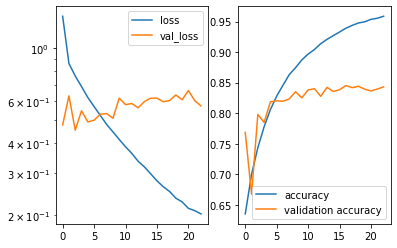


Epoch 00023: val_accuracy did not improve from 0.84511
3560/3560 [==============================] - 365s 103ms/step - accuracy: 0.9586 - loss: 0.2018 - val_accuracy: 0.8430 - val_loss: 0.5710
Epoch 00023: early stopping


In [10]:
# Train dense layers with base frozen
run_training(dropout = params['dropout'], lr_rate = params['learning_rate'], 
             architecture = params['architecture'], batch = params['batch_size'],
             epochs = params['epochs'], frozen_base=True)

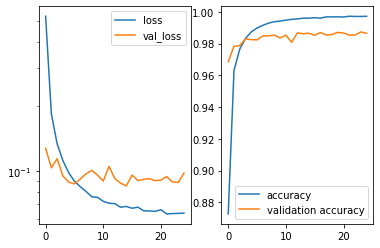


Epoch 00025: val_accuracy did not improve from 0.98731
3560/3560 [==============================] - 816s 229ms/step - loss: 0.0636 - accuracy: 0.9972 - val_loss: 0.0976 - val_accuracy: 0.9865


In [9]:
# Unfreeze all weights to fine-tine model
# NBNB this will use same learming rate type as specified in params unless you change it 
run_training(dropout = params['dropout'], lr_rate = params['learning_rate'], 
             architecture = params['architecture'], batch = params['batch_size'],
             epochs = params['epochs'], frozen_base=False)

In [10]:
# Save model to bucket from highest val acc weights
save_model_from_best_weights(dropout = 0.5, lr_rate = 0.0002, architecture = 'mobilenet', frozen_base=False)